Så først og fremmest få prio grid og UCDP merged og se hvad su så synes du mangler...

In [1]:
import numpy as np
from scipy import stats

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import seaborn as sns

import math
import time

from shapely.geometry import Point

full_script_time = time.time()

Gelman siger (måske): divider dine continuerlige variabler med 2 std_d for at de kommer til at ligene dine katagoriske var mere.... (https://www.youtube.com/watch?v=Jb9eklfbDyg 16.30)

In [2]:
def import_df():
    """Function for loading, handling and merging the data. Rigth now you don't use the prio gird thou.."""
    t1 = time.time()
    
    # load data:
    prio_grid = gpd.read_file("zip:///home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/priogrid_cellshp.zip")
    prio_static = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/static/PRIO-GRID Static Variables - 2018-08-21.csv")
    prio_yearly_interp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO_Yearly_interp.csv")
    prio_yearly = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO-GRID Yearly Variables for 1946-2014 - 2018-08-21.csv")
    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats
    
    # Choosing ("most") relevant variables:
    prio_grid_lean = prio_grid[['gid','geometry']]
    prio_static_lean = prio_static[['gid','landarea','ttime_mean','mountains_mean','petroleum_s']]
    prio_yearly_interp_lean = prio_yearly_interp[['gid','year','interp_pop_gpw_sum','interp_gcp_ppp','interp_urban_ih','interp_agri_ih','interp_forest_ih']]
    prio_yearly_lean = prio_yearly[['gid','year','gwno','gwarea','bdist1','bdist3','capdist','excluded','petroleum_y','nlights_calib_mean']] #bdist 3 er minimere nans
    ucdp_lean = ucdp[['priogrid_gid','country_id','region','year','best']]

    
    # Choosing relevant years: 
    prio_yearly_interp_lean_1990 = prio_yearly_interp_lean[(prio_yearly_interp_lean['year'] >= 1990) & (prio_yearly_interp_lean['year'] <= 2010)]
    prio_yearly_lean_1990 = prio_yearly_lean[(prio_yearly_lean['year'] >= 1990) & (prio_yearly_lean['year'] <= 2010)]
    ucdp_lean_1990 = ucdp_lean[(ucdp_lean['year'] >= 1990) & (ucdp_lean['year'] <= 2010)]
    
    # Aggregating yearly fatalities:
    ucdp_lean_1990_year_agg = ucdp_lean_1990.groupby(by=['priogrid_gid','country_id','year']).sum().reset_index() # det her virker.tror jeg
    ucdp_lean_1990_year_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_lean_1990_year_agg.rename(columns={'country_id':'gwno'}, inplace=True)
    
    
    # Merging
    prio_yearly_lean_1990_all = pd.merge(prio_yearly_interp_lean_1990, prio_yearly_lean_1990, on = ['gid','year'])

    prio_static_grid = prio_grid_lean.merge(prio_static_lean, on='gid', how='inner')
    prio_sy_grid = prio_static_grid.merge(prio_yearly_lean_1990_all, on = 'gid', how='inner')
    prio_sy_ucdp_grid = prio_sy_grid.merge(ucdp_lean_1990_year_agg, on = ['gid','year','gwno'], how='left')

    
    # Filling in cells with non-fatalities.
    prio_sy_ucdp_grid['best'].fillna(value=0, inplace = True)
    prio_sy_ucdp_grid['log_best'] = np.log(prio_sy_ucdp_grid['best']+1)
    
    # Managing petolium:
    prio_sy_ucdp_grid['petroleum_y'] = prio_sy_ucdp_grid.sort_values('year').groupby('gid')['petroleum_y'].fillna(method = 'ffill').copy() # fint
    prio_sy_ucdp_grid['petroleum_y'].fillna(0, inplace = True)
    prio_sy_ucdp_grid['petroleum_s'].fillna(0, inplace = True)
    
    prio_sy_ucdp_grid['petroleum_full'] = np.maximum(prio_sy_ucdp_grid['petroleum_y'],prio_sy_ucdp_grid['petroleum_s'])
    
    prio_sy_ucdp_grid.drop('petroleum_y', axis=1, inplace=True)
    prio_sy_ucdp_grid.drop('petroleum_s', axis=1, inplace=True)
                                                        
    # Managing bdist1 
    #prio_sy_ucdp_grid['bdist1'].fillna(np.median(prio_sy_ucdp_grid['bdist1']), inplace = True) # kunne være fedt bare at ordne det i modellen.
    
    df_done = prio_sy_ucdp_grid[prio_sy_ucdp_grid['gwno'].notna()] # removes 12 fucks.
    
    print('seconds it took load and handle data: ' + str(time.time()-t1))
    return(df_done) # ucdp for dist. to conflict var.
    
    # Should you normelize the data... espec teh y 'best'

In [3]:
def import_df_point():
    
    t1 = time.time()
    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 

    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats

    ucdp_1990 = ucdp[(ucdp['year'] >= 1990) & (ucdp['year'] <= 2010)]

    ucdp_1990_year_agg = ucdp_1990.groupby(by=['priogrid_gid','country_id','year', 'latitude', 'longitude']).sum().reset_index() # det her virker.tror jeg
    ucdp_1990_year_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_1990_year_agg.rename(columns={'country_id':'gwno'}, inplace=True)

    ucdp_lean_1990_year_agg = ucdp_1990_year_agg[['gid','gwno','year','best']]

    ucdp_1990_year_agg['Coordinates'] = list(zip(ucdp_1990_year_agg.longitude, ucdp_1990_year_agg.latitude))
    ucdp_1990_year_agg['Coordinates'] = ucdp_1990_year_agg['Coordinates'].apply(Point)

    gdf_point = gpd.GeoDataFrame(ucdp_1990_year_agg, geometry='Coordinates')

    print('seconds it took load and handle data: ' + str(time.time()-t1))
    return(gdf_point) # ucdp for dist. to conflict var.

    

In [4]:
df = import_df() # df_pint = ucdp for dist. to conflict var.
df_point = import_df_point()

# Hvad bruger du den til?
feature_list = ['landarea', 'ttime_mean', 'mountains_mean',
       'petroleum_full', 'year', 'interp_pop_gpw_sum', 'interp_gcp_ppp',
       'interp_urban_ih', 'interp_agri_ih', 'interp_forest_ih', 'gwno',
       'gwarea','bdist1', 'bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best']

df.shape


/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


seconds it took load and handle data: 114.36892414093018


/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


seconds it took load and handle data: 4.044646263122559


(1361166, 21)

In [5]:
df = df[df['gwno'].notna()] # removes 12 fucks.
df.shape

(1361166, 21)

In [6]:
def get_na(df=df):

    na_list = []
    
    for i in df.columns:
        proporiton_na = df[i].isna().sum()/len(df[i])
        print(i + " that is NA : " + str(round(proporiton_na*100, 3)) + '%')
        
        
        
        if proporiton_na > 0.01:
            na_list.append(i)
        
    return(na_list)

In [7]:
def fill_missing_1(df=df):
    
    # First back-extrapolating light values from 1992 to 91 and 90.
    
    Light_years = [1990, 1991]# full missing years for 'nlights_calib_mean'.
    missing_list = ['interp_urban_ih', 'interp_agri_ih', 'interp_forest_ih','mountains_mean','nlights_calib_mean']
    
    for y in Light_years:
        df.loc[df['year'] == y, 'nlights_calib_mean'] = df[df['year'] == 1992]['nlights_calib_mean'].values


    for f in missing_list:
        df.loc[df[f] < 0 , f] = 0 # due to rounding errors in the interpolation, few values a negative (still practical zero.)
    
        df[f].fillna(df[f].min(), inplace = True) # minimun in this case being zero.

fill_missing_1()

def fill_missing_2(df=df):
    
    # first bdist1:
    df['bdist1'].fillna(df['bdist1'].median(), inplace = True) # median and not mean, since it is is skewed - ofc should be corss-validated. 
    
    # Then, correct the interpolation:
    df.loc[df['interp_gcp_ppp'] < 0 , 'interp_gcp_ppp'] = 0 # due to rounding errors in the interpolation, few values a negative (still practical zero.)
    
    # fill forward:
    df['interp_gcp_ppp'] = df.sort_values('year').groupby('gid')['interp_gcp_ppp'].fillna(method = 'ffill')
    df['interp_gcp_ppp'] = df.sort_values('year').groupby('gid')['interp_gcp_ppp'].fillna(method = 'bfill')

    
    # Excluded = min
    df['excluded'].fillna(df['excluded'].min(), inplace = True) # tjek lige i codebogen om det her er khoser
    
    
fill_missing_2()
na_list = get_na()

gid that is NA : 0.0%
geometry that is NA : 0.0%
landarea that is NA : 0.0%
ttime_mean that is NA : 0.156%
mountains_mean that is NA : 0.0%
year that is NA : 0.0%
interp_pop_gpw_sum that is NA : 0.0%
interp_gcp_ppp that is NA : 2.057%
interp_urban_ih that is NA : 0.0%
interp_agri_ih that is NA : 0.0%
interp_forest_ih that is NA : 0.0%
gwno that is NA : 0.0%
gwarea that is NA : 0.0%
bdist1 that is NA : 0.0%
bdist3 that is NA : 0.0%
capdist that is NA : 0.0%
excluded that is NA : 0.0%
nlights_calib_mean that is NA : 0.0%
best that is NA : 0.0%
log_best that is NA : 0.0%
petroleum_full that is NA : 0.0%


Some justifications...

Of course, this hold 'missing vaules' inter/extrapolation ecxercise should under all surcomstances be performet under cross validation and would no doubt benifit from being traeated as a predictive problem in it self. I will show how to incoporate the laste few missing values in the model, and if time permits go back and test different approches. For now, this will serve, and if I do not find the time to go back this will be a challenge for the next project. 


**Så hvad nu?**

# C-shape dict (cool, but why?)

In [8]:
def my_import_2():
    cshapes = gpd.read_file("zip:////home/polichinel/Dropbox/KU/9.semester/friopgave/data/CShapes/cshapes_0.6.zip")
    cshapes.rename(columns={'CNTRY_NAME':'country_name','COWCODE':'gwno'}, inplace=True)
    cshapes_lean = cshapes[['country_name','gwno']]

    return(cshapes_lean)

cshapes_lean = my_import_2()
    
def country_lookup(gwno):
    if len(cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name']) != 0:
        country_name = cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name'].iloc[0]
        print(country_name)
    else:
        print('unknown gwno')
        
        
def country_lookup_out(gwno):
    
    c_list = []
    
    if len(cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name']) != 0:
        country_name = cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name'].iloc[0]
        c_list.append(country_name)
    else:
        c_list.append('unknown gwno')
        
    return(c_list)

In [9]:
country_lookup(1)

unknown gwno


In [10]:
country_lookup(2)

United States


Kan du få lande sørelse in her? du kan self også bare aggregere area på gwno og year...

Så det ser fint ud neden for, men du skal stadigt havde styr på olie og dine imputationer. Lige nu tror jeg du sætter alt til nul.. Det går ikke.. Det kan du gøre med best. Og måske et par andre, men det skal være gennemtænkt.

# Some light feature eginering:

### the y's:

In [12]:
# Creating the binary target:
df['binary_best'] = pd.Series(df['best'] > 0).astype('int') 

# Leading the binary target:
df['lead_binary_best'] = df.sort_values('year').groupby(['gid'])['binary_best'].shift(-1)

# Lead best
df['lead_best'] = df.sort_values('year').groupby(['gid'])['best'].shift(-1)

# Past fatalities
df['past_fatalities'] = df.sort_values('year').groupby(['gid'])['best'].cumsum()

#df['log_past_fatalities'] = np.log(df['past_fatalities'] + 1) # ordner du senere!

# Past conflicts
df['past_conflicts'] = df.sort_values('year').groupby(['gid'])['binary_best'].cumsum()

# Years since peace/conflict is handled defferently... later on

# Fatilities/conflict in country

df['fatilities_country_year'] = df.groupby(['gwno','year'])['best'].transform(np.sum)
df['conflict_country_year'] = np.array(df['fatilities_country_year'] > 0).astype(int)

# DIST TEST:

In [127]:
# with pool:
t0 = time.time()

years = np.arange(1990,2011)

def print_years(x):
    
    year = years[x]
    
    subset = df[df['year']==year].copy()
    subset_point = df_point[df_point['year']==year].copy()
    
    dist_nearest_conflict_list = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(subset.shape[0])]
    
    return(dist_nearest_conflict_list)


pool = mp.Pool(processes=8)
results = [pool.apply_async(print_years, args=(x,)) for x in range(years.shape[0])]

output = [p.get() for p in results]

t1 = time.time()-t0
print('minutes it took: ' + str(t1/60))

minutes it took: 248.45003904104232


Process ForkPoolWorker-633:
Process ForkPoolWorker-630:
Process ForkPoolWorker-637:
Traceback (most recent call last):
Process ForkPoolWorker-636:
Process ForkPoolWorker-631:
Traceback (most recent call last):
Process ForkPoolWorker-635:
Process ForkPoolWorker-634:
Traceback (most recent call last):
Process ForkPoolWorker-632:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py

In [142]:
def make_df_dict():
    
    df_dict = {}
        
    for i in range(years.shape[0]):
    
        year = years[i]
    
        subset = df[df['year']==year].copy()
        
        subset['nearest_conflict'] = output[i]
    
        df_name = 'subset_' + str(year) 
    
        df_dict[df_name]  = subset
    
    return(df_dict)

In [144]:
df_dict = make_df_dict()

In [147]:
df_dict['subset_2010'].shape

(64818, 29)

In [171]:
df = pd.concat([df_dict['subset_1990'],
                df_dict['subset_1991'],
                df_dict['subset_1992'],
                df_dict['subset_1993'],
                df_dict['subset_1994'],
                df_dict['subset_1995'],
                df_dict['subset_1996'],
                df_dict['subset_1997'],
                df_dict['subset_1998'],
                df_dict['subset_1999'],
                df_dict['subset_2000'],
                df_dict['subset_2001'],
                df_dict['subset_2002'],
                df_dict['subset_2003'],
                df_dict['subset_2004'],
                df_dict['subset_2005'],
                df_dict['subset_2006'],
                df_dict['subset_2007'],
                df_dict['subset_2008'],
                df_dict['subset_2009'],
                    df_dict['subset_2010']])

In [165]:
#full_df.to_file('full_df') # to file ->  it is a geopandas df! -> or just pickle it...

### Low and high ratios from Cederman, Gleditsch and Buhaug. p 105
Should be vectorized and mad into one function:

Mean kan vel også bruges som et relative mål for landet i forhold til andre lande?

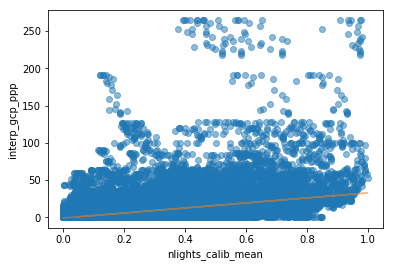

Slope: 33.7
Standart Error: 0.0446
P-value: 0.0
R²: 0.31


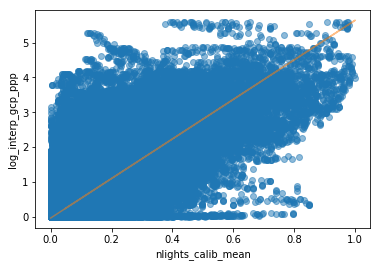

Slope: 5.67
Standart Error: 0.00436
P-value: 0.0
R²: 0.571


In [173]:
# show the corrolation between light and gcp:

def wealth_corr(df=df):

    data = df.dropna()

    # normal:
    x = data['nlights_calib_mean']
    y = data['interp_gcp_ppp']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('nlights_calib_mean')
    plt.ylabel('interp_gcp_ppp')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))

    # log gcp:
    x = data['nlights_calib_mean']
    y = np.log(data['interp_gcp_ppp'] +1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('nlights_calib_mean')
    plt.ylabel('log_interp_gcp_ppp')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    
    
wealth_corr()

## Der er et problem med alle nullerne i gcp. 
Det kan jo ikke passe at folk producere ingen ting.. Har du imputed noget eller er det sådan fra starten? og det er jo faktisk selvom der er ret lyst... Du skal helt sikkert overveje at droppe den..

In [12]:
# But shoul you then log_tranform GCP before the interactions? As fare as I can tell that is not what cederman and gang does..

In [174]:
# FOR light (WITH YEAR!!):

# Create vector of means
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['mean_light'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.mean) # this shit! Måske netop np.where herfra..

# Create vector base low_ratio (for now called low...)
df['low_ratio_light'] = (df[df['nlights_calib_mean'] < df['mean_light']]['mean_light']+1) / (df[df['nlights_calib_mean'] < df['mean_light']]['nlights_calib_mean']+1) # +1 tt avoid /0
df.loc[df['nlights_calib_mean'] >= df['mean_light'],'low_ratio_light'] = 1

# Create vector base high_ratio (for now called high...)
df['high_ratio_light'] = df[df['nlights_calib_mean'] > df['mean_light']]['nlights_calib_mean'] / df[df['nlights_calib_mean'] > df['mean_light']]['mean_light']
df.loc[df['nlights_calib_mean'] <= df['mean_light'],'high_ratio_light'] = 1

In [175]:
# FOR GCP(WITH YEAR!!):

# Create vector of means
# Den strafffer lande med mange tyndt eller ubeboet celler...
df['mean_gcp'] = df.groupby(['gwno','year'])['interp_gcp_ppp'].transform(np.mean) # this shit! Måske netop np.where herfra..

# Create vector base low_ratio (for now called low...)
df['low_ratio_gcp'] = (df[df['interp_gcp_ppp'] < df['mean_gcp']]['mean_gcp']+1) / (df[df['interp_gcp_ppp'] < df['mean_gcp']]['interp_gcp_ppp']+1) # +1 tt avoid /0
df.loc[df['interp_gcp_ppp'] >= df['mean_gcp'],'low_ratio_gcp'] = 1

# Create vector base high_ratio (for now called high...)
df['high_ratio_gcp'] = df[df['interp_gcp_ppp'] > df['mean_gcp']]['interp_gcp_ppp'] / df[df['interp_gcp_ppp'] > df['mean_gcp']]['mean_gcp']
df.loc[df['interp_gcp_ppp'] <= df['mean_gcp'],'high_ratio_gcp'] = 1

In [176]:
df[['high_ratio_light','low_ratio_light','high_ratio_gcp','low_ratio_gcp']].describe()

,high_ratio_light,low_ratio_light,high_ratio_gcp,low_ratio_gcp
count,1.361166e+06,1.361166e+06,1.333164e+06,1.333164e+06
mean,1.288303e+00,1.012347e+00,1.654332e+00,1.307266e+00
std,1.848843e+00,1.904707e-02,7.631091e+00,6.434020e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000421e+00,1.000000e+00,1.019375e+00
50%,1.000000e+00,1.006108e+00,1.000000e+00,1.111704e+00
75%,1.000000e+00,1.014252e+00,1.000000e+00,1.271907e+00
max,2.696986e+02,1.352020e+00,7.454143e+02,1.522379e+01


### Make a few interactions: 

#### Skal du logge gcp før interactionerne.. Eller efter?

In [177]:
# binary excluded vriabel. Asking 'if', not 'how many'.
df['excluded_binary'] = pd.Series(df['excluded'] > 0).astype('int') # burde være rigtig.. men funky resultater ved df['excluded_low_ratio_light']

# # interaction with original excluded:
# df['excluded_nlights'] = (df['excluded']+1) / (df['nlights_calib_mean']+1) # my own implimentation
# df['excluded_gcp'] = (df['excluded']+1) / (df['interp_gcp_ppp']+1) # my own implimentation

# # interaction with binary excluded:
# df['excluded_b_nlights'] = (df['excluded_binary']+1) / (df['nlights_calib_mean']+1) # my own implimentation
# df['excluded_b_gcp'] = (df['excluded_binary']+1) / (df['interp_gcp_ppp']+1) # my own implimentation

# # Teoritisk set er denne her altså bedre...
# df['excluded_b_nlights_alt'] = (df['excluded_binary']) / (df['nlights_calib_mean']+1) # my own implimentation
# df['excluded_b_gcp_alt'] = (df['excluded_binary']) / (df['interp_gcp_ppp']+1) # my own implimentation

# # ------------------------------


# Cederman, Gledisch and Buhaug:

# binary:
df['excluded_b_low_ratio_gcp'] = df['low_ratio_gcp'] * df['excluded_binary']

df['excluded_b_high_ratio_gcp'] = df['high_ratio_gcp']* df['excluded_binary']

df['excluded_b_low_ratio_light'] = df['low_ratio_light'] * df['excluded_binary']

df['excluded_b_high_ratio_light'] = df['high_ratio_light']* df['excluded_binary']

# Original:
df['excluded_low_ratio_gcp'] = df['low_ratio_gcp'] * df['excluded']

df['excluded_high_ratio_gcp'] = df['high_ratio_gcp']* df['excluded']

df['excluded_low_ratio_light'] = df['low_ratio_light'] * df['excluded']

df['excluded_high_ratio_light'] = df['high_ratio_light']* df['excluded']


# Not really the same as Cederman, Gledisch and Buhaug. Assumes that the excluded groups size is some positive function of total size..
df['excluded_pop'] = df['excluded'] * df['interp_pop_gpw_sum']
df['excluded_b_pop'] = df['excluded_binary'] * df['interp_pop_gpw_sum']

# --------------------------------------------
# relative deprevation (my) + inter action:

# If poeple compare with the top
# country(and year) specific standart diviation * cell exculded (binary)

# if poeple compare with most(median):
# distance (count or std. d?) to (country_year) medain from cell median * cell exculded (Denne her er måske faktisk bedst..)

# Create vector of mediab

# LIGHT:---------------------------------------------------
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['country_year_median_light'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.median) # this shit! Måske netop np.where herfra..

df['diff_median_light'] = df['country_year_median_light'] - df['nlights_calib_mean'] # should make this stop at zero

df['diff_median_light_zero'] = df['diff_median_light']

df.loc[df['diff_median_light_zero'] <=0, 'diff_median_light_zero'] = 0



df['diff_median_light_excluded_b_zero'] = df['diff_median_light_zero'] * df['excluded_binary']

df['diff_median_light_excluded'] = df['diff_median_light'] * df['excluded']

df['diff_median_light_excluded_b'] = df['diff_median_light'] * df['excluded_binary']



#df['diff_median_light_excluded_b_zero'] = 

# GCP: ---------------------------------------------------------------------------
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['country_year_median_gcp'] = df.groupby(['gwno','year'])['interp_gcp_ppp'].transform(np.median) # this shit! Måske netop np.where herfra..

df['diff_median_gcp'] = df['country_year_median_gcp'] - df['interp_gcp_ppp']


df['diff_median_gcp_zero'] = df['diff_median_gcp']

df.loc[df['diff_median_gcp_zero'] <=0, 'diff_median_gcp_zero'] = 0


df['diff_median_gcp_excluded_b_zero'] = df['diff_median_gcp_zero'] * df['excluded_binary']

df['diff_median_gcp_excluded'] = df['diff_median_gcp'] * df['excluded']

df['diff_median_gcp_excluded_b'] = df['diff_median_gcp'] * df['excluded_binary']

#df['diff_median_gcp_excluded_b_zero'] = 

# # Create vector base low_ratio (for now called low...)
# df['low_ratio_light'] = (df[df['nlights_calib_mean'] < df['mean_light']]['mean_light']+1) / (df[df['nlights_calib_mean'] < df['mean_light']]['nlights_calib_mean']+1) # +1 tt avoid /0
# df.loc[df['nlights_calib_mean'] >= df['mean_light'],'low_ratio_light'] = 1

# # Create vector base high_ratio (for now called high...)
# df['high_ratio_light'] = df[df['nlights_calib_mean'] > df['mean_light']]['nlights_calib_mean'] / df[df['nlights_calib_mean'] > df['mean_light']]['mean_light']
# df.loc[df['nlights_calib_mean'] <= df['mean_light'],'high_ratio_light'] = 1



# if people compare with mean:
# Distance (count or std. d?) to (country_year) mean from cell mean * cell excluded

# De to sidste kunne dog også lave med world mean and median? -> kommer fra Goldstone 2010.. Det er grund nok.


# Distance from (cell) median to (world/country/cell?) mean * excluded!


### Country pop and size

In [178]:
# Virker fint

df['country_area_sum'] = df.groupby(['gwno','year'])['landarea'].transform(np.sum) # this shit! Måske netop np.where herfra..
df['country_pop_sum'] = df.groupby(['gwno','year'])['interp_pop_gpw_sum'].transform(np.sum) # this shit! Måske netop np.where herfra..


In [179]:
df[(df['gwno'] == 2 ) & (df['year'] == 2010)][['country_area_sum','country_pop_sum']].head() # passer på usa wiki areal og folke tælling 2010. ca.

,country_area_sum,country_pop_sum
65584,9.428286e+06,3.086483e+08
65605,9.428286e+06,3.086483e+08
65626,9.428286e+06,3.086483e+08
65647,9.428286e+06,3.086483e+08
65668,9.428286e+06,3.086483e+08


# pop dens country and cell:

In [180]:
# mass divided by volumen

df['pop_cell_dens'] = df['interp_pop_gpw_sum']/(df['landarea']+1) # men det her med 1 dur ikke..
df['pop_country_dens'] = df['country_pop_sum']/(df['country_area_sum']+1)

# interaction with excluded:

df['pop_cell_dens_excluded'] = df['pop_cell_dens'] * df['excluded']

df['pop_cell_dens_excluded_b'] = df['pop_cell_dens'] * df['excluded_binary']

# det med + 1 går nok ikke men det ser ellers fint ud...
# men der burde heller ikke være nogen med 0? og hvis der er gør +1 minimal forskel...

# Pop corrected variabeles:

**Kan du ikke bare dividere nlight-country-year-mean med country-pop???**

### Andre interaktion eller transformation fra litteraturen? 
**Overvej også at behandle best som en tidsserie og brug fremskrivningen som som variable - både count og slope. **
- Ja, men det er jo lidt det den kommende guassian process i modellen burde gøre... Right?

- Low and high ratio are effectivly inequality before the interaction.

- Hvad sker der for politisk system og infant mortality? Det bliver du nød til at snakke om... Politisk system måske med henvisning til at når man ikke bruger Polity IV har littereaturen ikke fundet meget... Infant mort fordi der kun er et år..

### Logs:
**Her skal der sorteres ud!!!** Men nye skal også in. igen er det nok lettest at lave en negtiv liste..

In [181]:
# New

def log_transformation(df = df):
    
    features_not_to_log = ['gid','geometry','year','gwno',
                           'excluded','petroleum_full','log_best','best']  # lead_binary_best
    # log_best already definded.. Men hvorfor har du gjort det?
    
    
    for feature in df.columns:
        
        if feature not in features_not_to_log:
    
            feature_name = 'log_' + feature
    
            df[feature_name] = np.log(df[feature] + 1)

log_transformation()

/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [182]:
df.describe()

,gid,landarea,ttime_mean,mountains_mean,year,interp_pop_gpw_sum,interp_gcp_ppp,interp_urban_ih,interp_agri_ih,interp_forest_ih,...,log_diff_median_gcp_zero,log_diff_median_gcp_excluded_b_zero,log_diff_median_gcp_excluded,log_diff_median_gcp_excluded_b,log_country_area_sum,log_country_pop_sum,log_pop_cell_dens,log_pop_country_dens,log_pop_cell_dens_excluded,log_pop_cell_dens_excluded_b
count,1.361166e+06,1.361166e+06,1.359045e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.333164e+06,1.361166e+06,1.361166e+06,1.361166e+06,...,1.333164e+06,1.333164e+06,1.302411e+06,1.306694e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.361166e+06
mean,1.744246e+05,2.036876e+03,1.187741e+03,2.400670e-01,2.000000e+03,9.318020e+04,7.070617e-01,2.611628e-01,9.266413e+00,2.002904e+01,...,4.137375e-02,1.324911e-02,-1.827307e-02,-1.858046e-02,1.504342e+01,1.784650e+01,1.788640e+00,2.913675e+00,5.489580e-01,5.270001e-01
std,4.581800e+04,8.691272e+02,1.690242e+03,3.599505e-01,6.055276e+00,3.593460e+05,4.173917e+00,1.699702e+00,1.835081e+01,3.245662e+01,...,1.582122e-01,6.074386e-02,2.239986e-01,2.173766e-01,1.561769e+00,1.595408e+00,1.845913e+00,1.261145e+00,1.264151e+00,1.211527e+00
min,4.918200e+04,2.559617e-06,5.123288e+00,0.000000e+00,1.990000e+03,-4.336809e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-8.451499e+00,-8.451499e+00,3.342326e+00,8.564526e+00,0.000000e+00,8.987136e-01,0.000000e+00,0.000000e+00
25%,1.407950e+05,1.391276e+03,2.227483e+02,0.000000e+00,1.995000e+03,2.129668e+02,2.946746e-03,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.396928e+01,1.683403e+01,1.393197e-01,2.217514e+00,0.000000e+00,0.000000e+00
50%,1.842010e+05,2.195231e+03,5.082728e+02,0.000000e+00,2.000000e+03,4.085204e+03,2.414200e-02,0.000000e+00,1.900000e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.585695e+01,1.767185e+01,1.134751e+00,2.654585e+00,0.000000e+00,0.000000e+00
75%,2.129270e+05,2.818335e+03,1.483922e+03,4.500000e-01,2.005000e+03,4.235912e+04,2.333571e-01,0.000000e+00,8.200000e+00,3.051700e+01,...,9.114266e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.610923e+01,1.881680e+01,3.059354e+00,3.689475e+00,1.469737e-01,1.463061e-01
max,2.493440e+05,3.091067e+03,3.003262e+04,1.000000e+00,2.010000e+03,1.827816e+07,2.646676e+02,7.811000e+01,1.000000e+02,1.000000e+02,...,3.187464e+00,2.061403e+00,2.587496e+00,2.061403e+00,1.690503e+01,2.102392e+01,1.184343e+01,9.064980e+00,9.493296e+00,9.493296e+00


In [183]:
# Lead best
df['lead_log_best'] = df.sort_values('year').groupby(['gid'])['log_best'].shift(-1)

In [ ]:
import pickle 
    
file_name = "full_df.pkl"
output = open(file_name, 'wb') # still not working right!!
pickle.dump(df, output)
output.close()

In [187]:

pkl_file = open('full_df.pkl', 'rb')

pickle_test_gdf = pickle.load(pkl_file)

pkl_file.close()

In [190]:
pickle_test_gdf.shape

(1361166, 121)

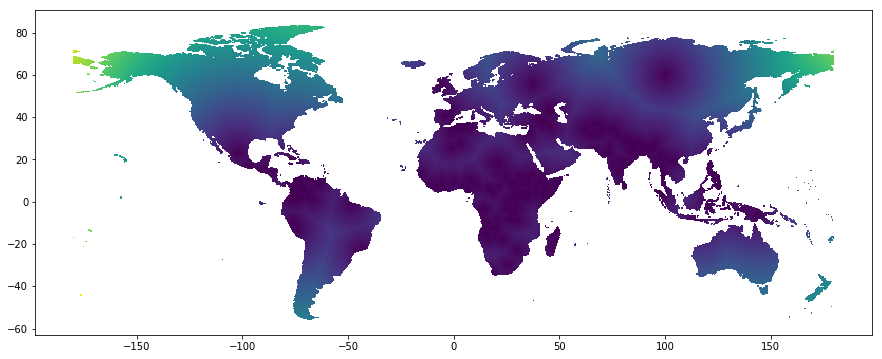

In [192]:
pickle_test_gdf[pickle_test_gdf['year']==2002].plot(column = 'nearest_conflict', figsize=(15, 15))
plt.show()